# 消费行为分析与消费细分模型

## 初始化与导入数据

In [35]:
import pandas as pd
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from  matplotlib.colors import  rgb2hex
import numpy as np
import warnings
# 解决matplotlib无法正常显示中文的问题
plt.rcParams['font.sans-serif'] = ['STHeiti'] 
# plt.rcParams['font.sans-serif'] = ['Simhei']
plt.rcParams['axes.unicode_minus'] = False
amount = pd.read_csv('consume.csv')
# 筛选出所有的非公共消费，有部分消费是水电费等消费
amount = amount[amount.Dept.str.contains('食')|amount.Dept.str.contains('超市')]

## 创建消费特征表

In [10]:
# 创建一个表
dict_list = []
# 统计学生消费特征
for name, group in amount.groupby(amount['CardNo']):
    money = group['Money'].agg(['sum','mean','max'])
    # 创建一条记录
    dict_t = {
        'CardNo': name,
        'AvgSurplus': format(group['Surplus'].agg(['mean'])[0], '.2f'),
        'TotalConsume': format(money[0], '.2f'),
        'AvgConsume': format(money[1], '.2f'),
        'MaxConsume': money[2],
        'Freq': group.shape[0]
    }
    dict_list.append(dict_t)
# 导出成DataFrame
evaluation = pd.DataFrame(dict_list[0:])
# 筛选掉所有消费频率低于30次的数据，认为是不正常的
evaluation = evaluation[evaluation.Freq>=30]
evaluation.to_csv('evaluation.csv')

# 基于DFM(Deposit、Frequency、Monetary)模型的K-Means分类

为了适用我们的题目，我们受到RFC模型的影响，选出了Deposit(储蓄)、Frequency(消费频率)、Monetray(消费金额)作为我们的模型评价标准。

基于此，进行K-Means分类。

## 通过Elbow Method求K-Means最佳k值

当k小于真实聚类数时，由于k的增大会大幅增加每个簇的聚合程度，故 SSE 的下降幅度会很大。

而当k到达真实聚类数时，再增加k所得到的聚合程度回报会迅速变小，所以 SSE 的下降幅度会骤减，随着k值的继续增大而趋于平缓。

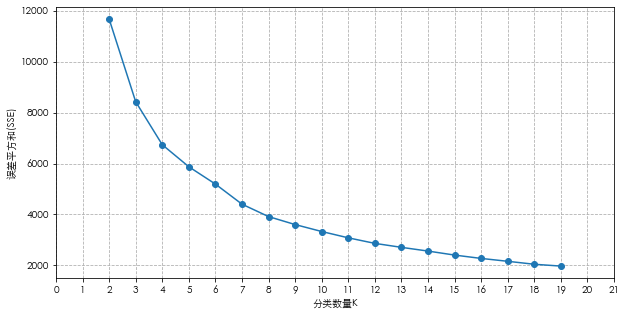

In [11]:
#你准备数据
training_data = evaluation.loc[0:, ['AvgSurplus','TotalConsume','Freq']]

# 存放每次结果的误差平方和
SSE = []
for k in range(2,20):
    km = KMeans(n_clusters=k)  # 构造聚类器
    scaler = StandardScaler()
    pipline = make_pipeline(scaler,km) 
    pipline.fit(training_data)
    SSE.append(km.inertia_)
# inertia_:样本到其最近聚类中心的平方距离之和
plt.figure(figsize=(10,5))   
plt.plot(range(2,20),SSE,'o-')
plt.xticks(range(0,22,1)) 
plt.grid(linestyle='--')
plt.xlabel("分类数量K")
plt.ylabel('误差平方和(SSE)')
plt.savefig('2-1.png',dpi=300)

## 基于DFM(Deposit、Frequency、Monetary)模型的K-Means分类

由上图可以认为最佳的K值在5左右，我们选取5。

In [12]:
# 创建kmeans模型并标准化
km = KMeans(n_clusters=5)
# scaler = MinMaxScaler(feature_range=(0, 1))
scaler = StandardScaler()
pipline = make_pipeline(scaler,km)
# 训练kmeans模型

pipline.fit(training_data)
# 预测数据的Labels
evaluation['Labels'] = pipline.predict(training_data)
# 保存数据
evaluation.to_csv('result.csv')

## 渲染3D散点图

drawing label 0
drawing label 1
drawing label 2
drawing label 3
drawing label 4


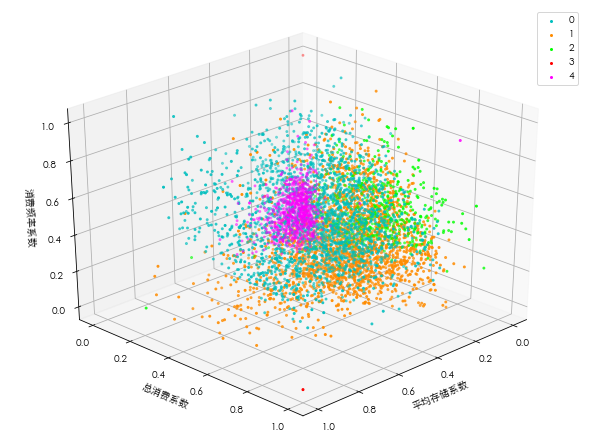

In [13]:

from sklearn.preprocessing import MinMaxScaler
fig = plt.figure(figsize=(8,6))
# 创建3D图
ax = Axes3D(fig)
colors = ['c', 'darkorange', 'lime', 'red', 'fuchsia', 'yellow']
for name, group in evaluation.groupby(evaluation['Labels']):
    std = MinMaxScaler(feature_range=(0, 1))
    x=std.fit_transform(group['AvgSurplus'].values.reshape(-1, 1))
    y=std.fit_transform(group['TotalConsume'].values.reshape(-1, 1))
    z=std.fit_transform(group['Freq'].values.reshape(-1, 1))
    print('drawing label {}'.format(name))
    ax.scatter3D(x, y, z, c=colors[name], label=name,s=4)
ax.view_init(30, 45)
ax.set_xlabel('平均存储系数')
ax.set_ylabel('总消费系数')
ax.set_zlabel('消费频率系数')
plt.legend()
plt.savefig('2-2.png',dpi=300)

## 结果分析

大致可以看到三大主类，还有一些松散的，我们需要找的是在最里面角落的那一类。



In [39]:
# 根据上图请自行调整，因为K-Means分类的label值不稳定，所以每次运行完前面的无比更改这个值
# 这个类是上图中所有项都最低的那一个类
group_label = 1
deep_model = evaluation[evaluation.Labels==group_label]
deep_model['AvgSurplus'] = deep_model['AvgSurplus'].astype("float64")
deep_model['TotalConsume'] = deep_model['TotalConsume'].astype("float64")
deep_model

,CardNo,AvgSurplus,TotalConsume,AvgConsume,MaxConsume,Freq,Labels
0,9,52.56,110.9,2.46,8.0,45,1
12,4462,44.12,190.1,3.52,12.0,54,1
21,6145,60.69,144.7,3.29,8.0,44,1
31,8702,87.85,113.2,3.43,10.0,33,1
38,9027,58.63,127.0,2.76,10.0,46,1
...,...,...,...,...,...,...,...
8331,186144,48.55,224.3,3.35,10.0,67,1
8333,186147,60.46,178.4,2.38,8.0,75,1
8334,186148,65.94,114.9,2.44,5.3,47,1
8335,186149,56.83,119.5,3.32,13.7,36,1


## 基于AHP算法评估需要补助的优先级

**感谢提供函数支持：**
- https://www.guofei.site/2020/01/05/ahp.html
- https://blog.csdn.net/aBIT_Tu/article/details/84029849

In [37]:
## 生成比较矩阵
def comparision(vec:list):  # W为每个信息值的权重
    n=len(vec)
    F=np.zeros([n,n])
    for i in range(n):
        for j in range(n):
            if i==j:
                F[i,j]=1
            else:
                F[i,j]=vec[i]/vec[j]
    return F


## AHP类
class AHP:
    def __init__(self, criteria, b):
        self.RI = (0, 0, 0.58, 0.9, 1.12, 1.24, 1.32, 1.41, 1.45, 1.49)
        self.criteria = criteria
        self.b = b
        self.num_criteria = criteria.shape[0]
        self.num_project = b[0].shape[0]

    def cal_weights(self, input_matrix):
        input_matrix = np.array(input_matrix)
        n, n1 = input_matrix.shape
        assert n == n1, '不是一个方阵'
        for i in range(n):
            for j in range(n):
                if np.abs(input_matrix[i, j] * input_matrix[j, i] - 1) > 1e-7:
                    raise ValueError('不是反互对称矩阵')

        eigenvalues, eigenvectors = np.linalg.eig(input_matrix)

        max_idx = np.argmax(eigenvalues)
        max_eigen = eigenvalues[max_idx].real
        eigen = eigenvectors[:, max_idx].real
        eigen = eigen / eigen.sum()

        if n > 9:
            CR = None
            warnings.warn('无法判断一致性')
        else:
            CI = (max_eigen - n) / (n - 1)
            CR = CI / self.RI[n]
        return max_eigen, CR, eigen

    def run(self):
        max_eigen, CR, criteria_eigen = self.cal_weights(self.criteria)
        print('准则层：最大特征值{:<5f},CR={:<5f},检验{}通过'.format(max_eigen, CR, '' if CR < 0.1 else '不'))
        print('准则层权重={}\n'.format(criteria_eigen))

        max_eigen_list, CR_list, eigen_list = [], [], []
        for i in self.b:
            max_eigen, CR, eigen = self.cal_weights(i)
            max_eigen_list.append(max_eigen)
            CR_list.append(CR)
            eigen_list.append(eigen)

        pd_print = pd.DataFrame(eigen_list,
                                index=['准则' + str(i) for i in range(self.num_criteria)],
                                columns=['方案' + str(i) for i in range(self.num_project)],
                                )
        pd_print.loc[:, '最大特征值'] = max_eigen_list
        pd_print.loc[:, 'CR'] = CR_list
        pd_print.loc[:, '一致性检验'] = pd_print.loc[:, 'CR'] < 0.1
        print('方案层')
        print(pd_print)

        # 目标层
        obj = np.dot(criteria_eigen.reshape(1, -1), np.array(eigen_list))
        print('\n目标层', obj)
        print('最优选择是方案{}'.format(np.argmax(obj)))
        return obj

criteria = comparision([1,5,3])
b = [
    comparision(deep_model['AvgSurplus'].values),
    comparision(deep_model['TotalConsume'].values),
    comparision(deep_model['Freq'].values)
]

results = AHP(criteria, b).run()

准则层：最大特征值3.000000,CR=0.000000,检验通过
准则层权重=[0.11111111 0.55555556 0.33333333]

方案层
          方案0       方案1       方案2       方案3       方案4       方案5       方案6  \
准则0  0.000377  0.000316  0.000435  0.000630  0.000420  0.000509  0.000152   
准则1  0.000243  0.000416  0.000317  0.000248  0.000278  0.000271  0.000178   
准则2  0.000380  0.000456  0.000372  0.000279  0.000389  0.000296  0.000405   

          方案7       方案8       方案9  ...    方案2434    方案2435    方案2436  \
准则0  0.000417  0.000548  0.000328  ...  0.000716  0.000601  0.000348   
准则1  0.000276  0.000413  0.000401  ...  0.000535  0.000262  0.000491   
准则2  0.000313  0.000346  0.000253  ...  0.000279  0.000346  0.000566   

       方案2437    方案2438    方案2439    方案2440   最大特征值    CR  一致性检验  
准则0  0.000434  0.000473  0.000408  0.000568  2441.0  None  False  
准则1  0.000390  0.000251  0.000262  0.000603  2441.0  None  False  
准则2  0.000634  0.000397  0.000304  0.000414  2441.0  None  False  

[3 rows x 2444 columns]

目标层 [[0.00030343 0.00041834

### 显示结果，Rank值越低补助的优先级越高

In [45]:
deep_model['Rank'] = results[0]
deep_model.sort_values(by='Rank')

,CardNo,AvgSurplus,TotalConsume,AvgConsume,MaxConsume,Freq,Labels,Rank,
6296,182989,23.87,21.0,0.51,3.0,41,1,0.000160,0.000160
978,163632,23.98,49.0,1.63,5.5,30,1,0.000163,0.000163
8074,185568,28.45,57.8,1.93,5.0,30,1,0.000177,0.000177
7153,184210,20.48,60.2,1.88,5.5,32,1,0.000180,0.000180
5452,181878,23.15,62.3,1.89,4.0,33,1,0.000187,0.000187
...,...,...,...,...,...,...,...,...,...
6346,183062,75.95,299.5,5.76,11.0,52,1,0.000571,0.000571
4062,180009,89.80,304.8,6.63,10.5,46,1,0.000572,0.000572
5934,182499,90.06,275.2,4.66,18.0,59,1,0.000572,0.000572
2813,172455,57.17,327.1,7.11,16.0,46,1,0.000573,0.000573
